<a href="https://colab.research.google.com/github/rohita77/Utils/blob/master/Google-vision-jpeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Imports and Installs

In [0]:
!pip install google.cloud.vision
!pip install google.cloud.storage

In [0]:
!apt-get -qq install -y google.protobuf

In [0]:
!export GOOGLE_APPLICATION_CREDENTIALS='ml-poc-1142c4445276.json'

In [0]:
 from google.cloud import vision
 from google.cloud import storage
 from google.protobuf import json_format
 import re
import numpy as np

In [0]:
import argparse
from enum import Enum
import io
import requests
from six.moves.urllib.request import urlopen
from six import BytesIO


In [0]:
from google.cloud.vision import types
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


In [0]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5

## 2. Settings

In [0]:
key_path = 'ml-poc-1142c4445276.json'

In [0]:
gcs_uri = 'https://storage.googleapis.com/'

In [0]:
client = vision.ImageAnnotatorClient.from_service_account_json(key_path)

## 3. Definitions

In [0]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


In [0]:
def detect_document_uri(uri):
    """Detects document features in the file located in Google Cloud
    Storage."""
    image = vision.types.Image()
    image.source.image_uri = uri

    response = client.document_text_detection(image=image)
   
    for page in response.full_text_annotation.pages:
      
        for block in page.blocks:
            print('\nBlock confidence: {:.2f}\n'.format(block.confidence))

            for paragraph in block.paragraphs:
                print('Paragraph confidence: {:.2f}'.format(
                    paragraph.confidence))

                for word in paragraph.words:
                    word_text = ''.join([
                        symbol.text for symbol in word.symbols
                    ])
                    print('Word text: {} ({:.1f})'.format(
                        word_text, word.confidence))

                    #for symbol in word.symbols:
                     #   print('\tSymbol: {} (confidence: {})'.format(
                      #      symbol.text, symbol.confidence))
            
        return response.full_text_annotation

In [0]:
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

     
    for bound in bounds:
        draw.line([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], width=2,fill=color)
    return image

In [0]:
def get_document_bounds(document, feature):
    """Returns document bounds given an image."""

    bounds = []

    # Collect specified feature bounds by enumerating all document features
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)

                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)

                if (feature == FeatureType.PARA):
                    bounds.append(paragraph.bounding_box)

            if (feature == FeatureType.BLOCK):
                bounds.append(block.bounding_box)

        if (feature == FeatureType.PAGE):
            bounds.append(block.bounding_box)

    # The list `bounds` contains the coordinates of the bounding boxes.
    return bounds

In [0]:
def render_doc_text(uri, fileout):
    #image = Image.open(filein)
    
    #image = vision.types.Image()
    #image.source.image_uri = filein
    
    #response = client.document_text_detection(image=image)

    ext = uri[-4:]
    
    if ext.find('.tif') > -1 :
      document = async_detect_document('gs://' + uri, fileout)
    else:
      document = detect_document_uri('gs://' + uri)
 

    response = urlopen(gcs_uri + uri)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  
  
    bounds = get_document_bounds(document, FeatureType.PAGE)
    draw_boxes(image, bounds, 'blue')
    bounds = get_document_bounds(document, FeatureType.PARA)
    draw_boxes(image, bounds, 'red')
    bounds = get_document_bounds(document, FeatureType.WORD)
    draw_boxes(image, bounds, 'yellow')

    #display_image(image)

#    if fileout is not 0:
#        image.save(fileout)
#
    # Here we print the full text from the first page.
    # The response contains more information:
    # annotation/pages/blocks/paragraphs/words/symbols
    # including confidence scores and bounding boxes
    print(u'Full text:\n{}'.format(
        document.text))
    
    return image

In [0]:
def async_detect_document(gcs_source_uri, gcs_destination_uri):
    """OCR with PDF/TIFF as source files on GCS"""
    # Supported mime_types are: 'application/pdf' and 'image/tiff'
    mime_type = 'image/tiff'

    # How many pages should be grouped into each json ou9tput file.
    batch_size = 2

    client = vision.ImageAnnotatorClient.from_service_account_json(key_path)

    feature = vision.types.Feature(
        type=vision.enums.Feature.Type.DOCUMENT_TEXT_DETECTION)

    gcs_source = vision.types.GcsSource(uri=gcs_source_uri)
    input_config = vision.types.InputConfig(
        gcs_source=gcs_source, mime_type=mime_type)

    gcs_destination = vision.types.GcsDestination(uri=gcs_destination_uri)
    output_config = vision.types.OutputConfig(
        gcs_destination=gcs_destination, batch_size=batch_size)

    async_request = vision.types.AsyncAnnotateFileRequest(
        features=[feature], input_config=input_config,
        output_config=output_config)

    operation = client.async_batch_annotate_files(
        requests=[async_request])

    print('Waiting for the operation to finish.')
    operation.result(timeout=180)

    # Once the request has completed and the output has been
    # written to GCS, we can list all the output files.
    storage_client = storage.Client.from_service_account_json(key_path)

    match = re.match(r'gs://([^/]+)/(.+)', gcs_destination_uri)
    bucket_name = match.group(1)
    prefix = match.group(2)

    bucket = storage_client.get_bucket(bucket_name=bucket_name)

    # List objects with the given prefix.
    blob_list = list(bucket.list_blobs(prefix=prefix))
    print('Output files:')
    for blob in blob_list:
        print(blob.name)

    # Process the first output file from GCS.
    # Since we specified batch_size=2, the first response contains
    # the first two pages of the input file.
    output = blob_list[0]

    json_string = output.download_as_string()
    response = json_format.Parse(
        json_string, vision.types.AnnotateFileResponse())

    # The actual response for the first page of the input file.
    first_page_response = response.responses[0]
    annotation = first_page_response.full_text_annotation

   
    return annotation

## 4. Examples

  

> #### OCR for NRIC



In [0]:
#detect_document_uri('gs://ml-poc-213704-vcm/EP.png')


Block confidence: 0.98

Paragraph confidence: 0.99
Word text: PERSONALISED (1.0)
Word text: EMPLOYMENT (1.0)
Word text: PASS (1.0)
Word text: Employment (1.0)
Word text: of (1.0)
Word text: Foreign (1.0)
Word text: Manpower (1.0)
Word text: Act (1.0)
Word text: ( (0.9)
Word text: Chapter (1.0)
Word text: 91A (1.0)
Word text: ) (1.0)
Paragraph confidence: 0.98
Word text: Republic (1.0)
Word text: of (1.0)
Word text: Singapore (1.0)
Word text: THIS (1.0)
Word text: PERSON (1.0)
Word text: IS (1.0)
Word text: A (1.0)
Word text: PERSONALISED (0.9)
Word text: EMPLOYMENT (1.0)
Word text: PASS (1.0)
Word text: HOLDER (1.0)

Block confidence: 0.97

Paragraph confidence: 0.97
Word text: Employer (1.0)

Block confidence: 0.98

Paragraph confidence: 0.98
Word text: Name (1.0)
Word text: ACHARYAF (1.0)

Block confidence: 0.93

Paragraph confidence: 0.93
Word text: V (0.8)
Word text: A (0.9)
Word text: RAMAKRISHNA (0.9)

Block confidence: 0.95

Paragraph confidence: 0.95
Word text: Occupation (0.9

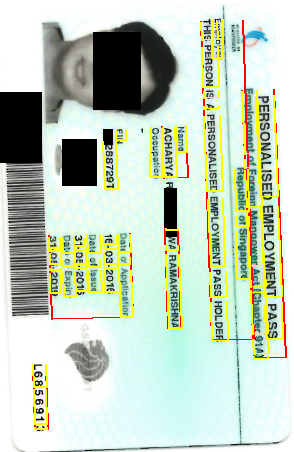

In [0]:
render_doc_text('ml-poc-213704-vcm/EP.png', 0)

In [0]:
async_detect_document('gs://ml-poc-213704-vcm/AliceTan.tif', 'gs://ml-poc-213704-vcm/upoad/output/')

> #### Full Credit Card Application for Alice Tan

Waiting for the operation to finish.
Output files:
upoad/output/output-1-to-1.json
Full text:
UOB CREDIT CARDS AND UOB CASHPLUS APPLICATION FORM
.
.
:.
:.::...
United Overseas Bank Limited Tel: 1800 222 2121 Fax: 6787 1531
SUPPLEMENTARY CARD APPLICATION (Al fields are mandatory)
Nationality
Country of Residence
Country you he currently residing in or intend to rende In, for more
than I yeur le Singapore)
ID/Passport issuing country:
2 EASY WAYS TO APPLY FAX: 6787 1531 or Mail it back to us
Yes, I would like to have my new card(s) couriered to my mailing address at a nominal fee of S$10.
Please complete all fields and attach the required documents. Applications with incomplete information or supporting
documents will result in delay in processing,
Existing UOB Principal Cardmembers only need to complete Section 1 and 7 and sign under Section 1, For your convenience,
no income documents will be required. If you have had a change of employment, please also complete Section 8 and attach
yo

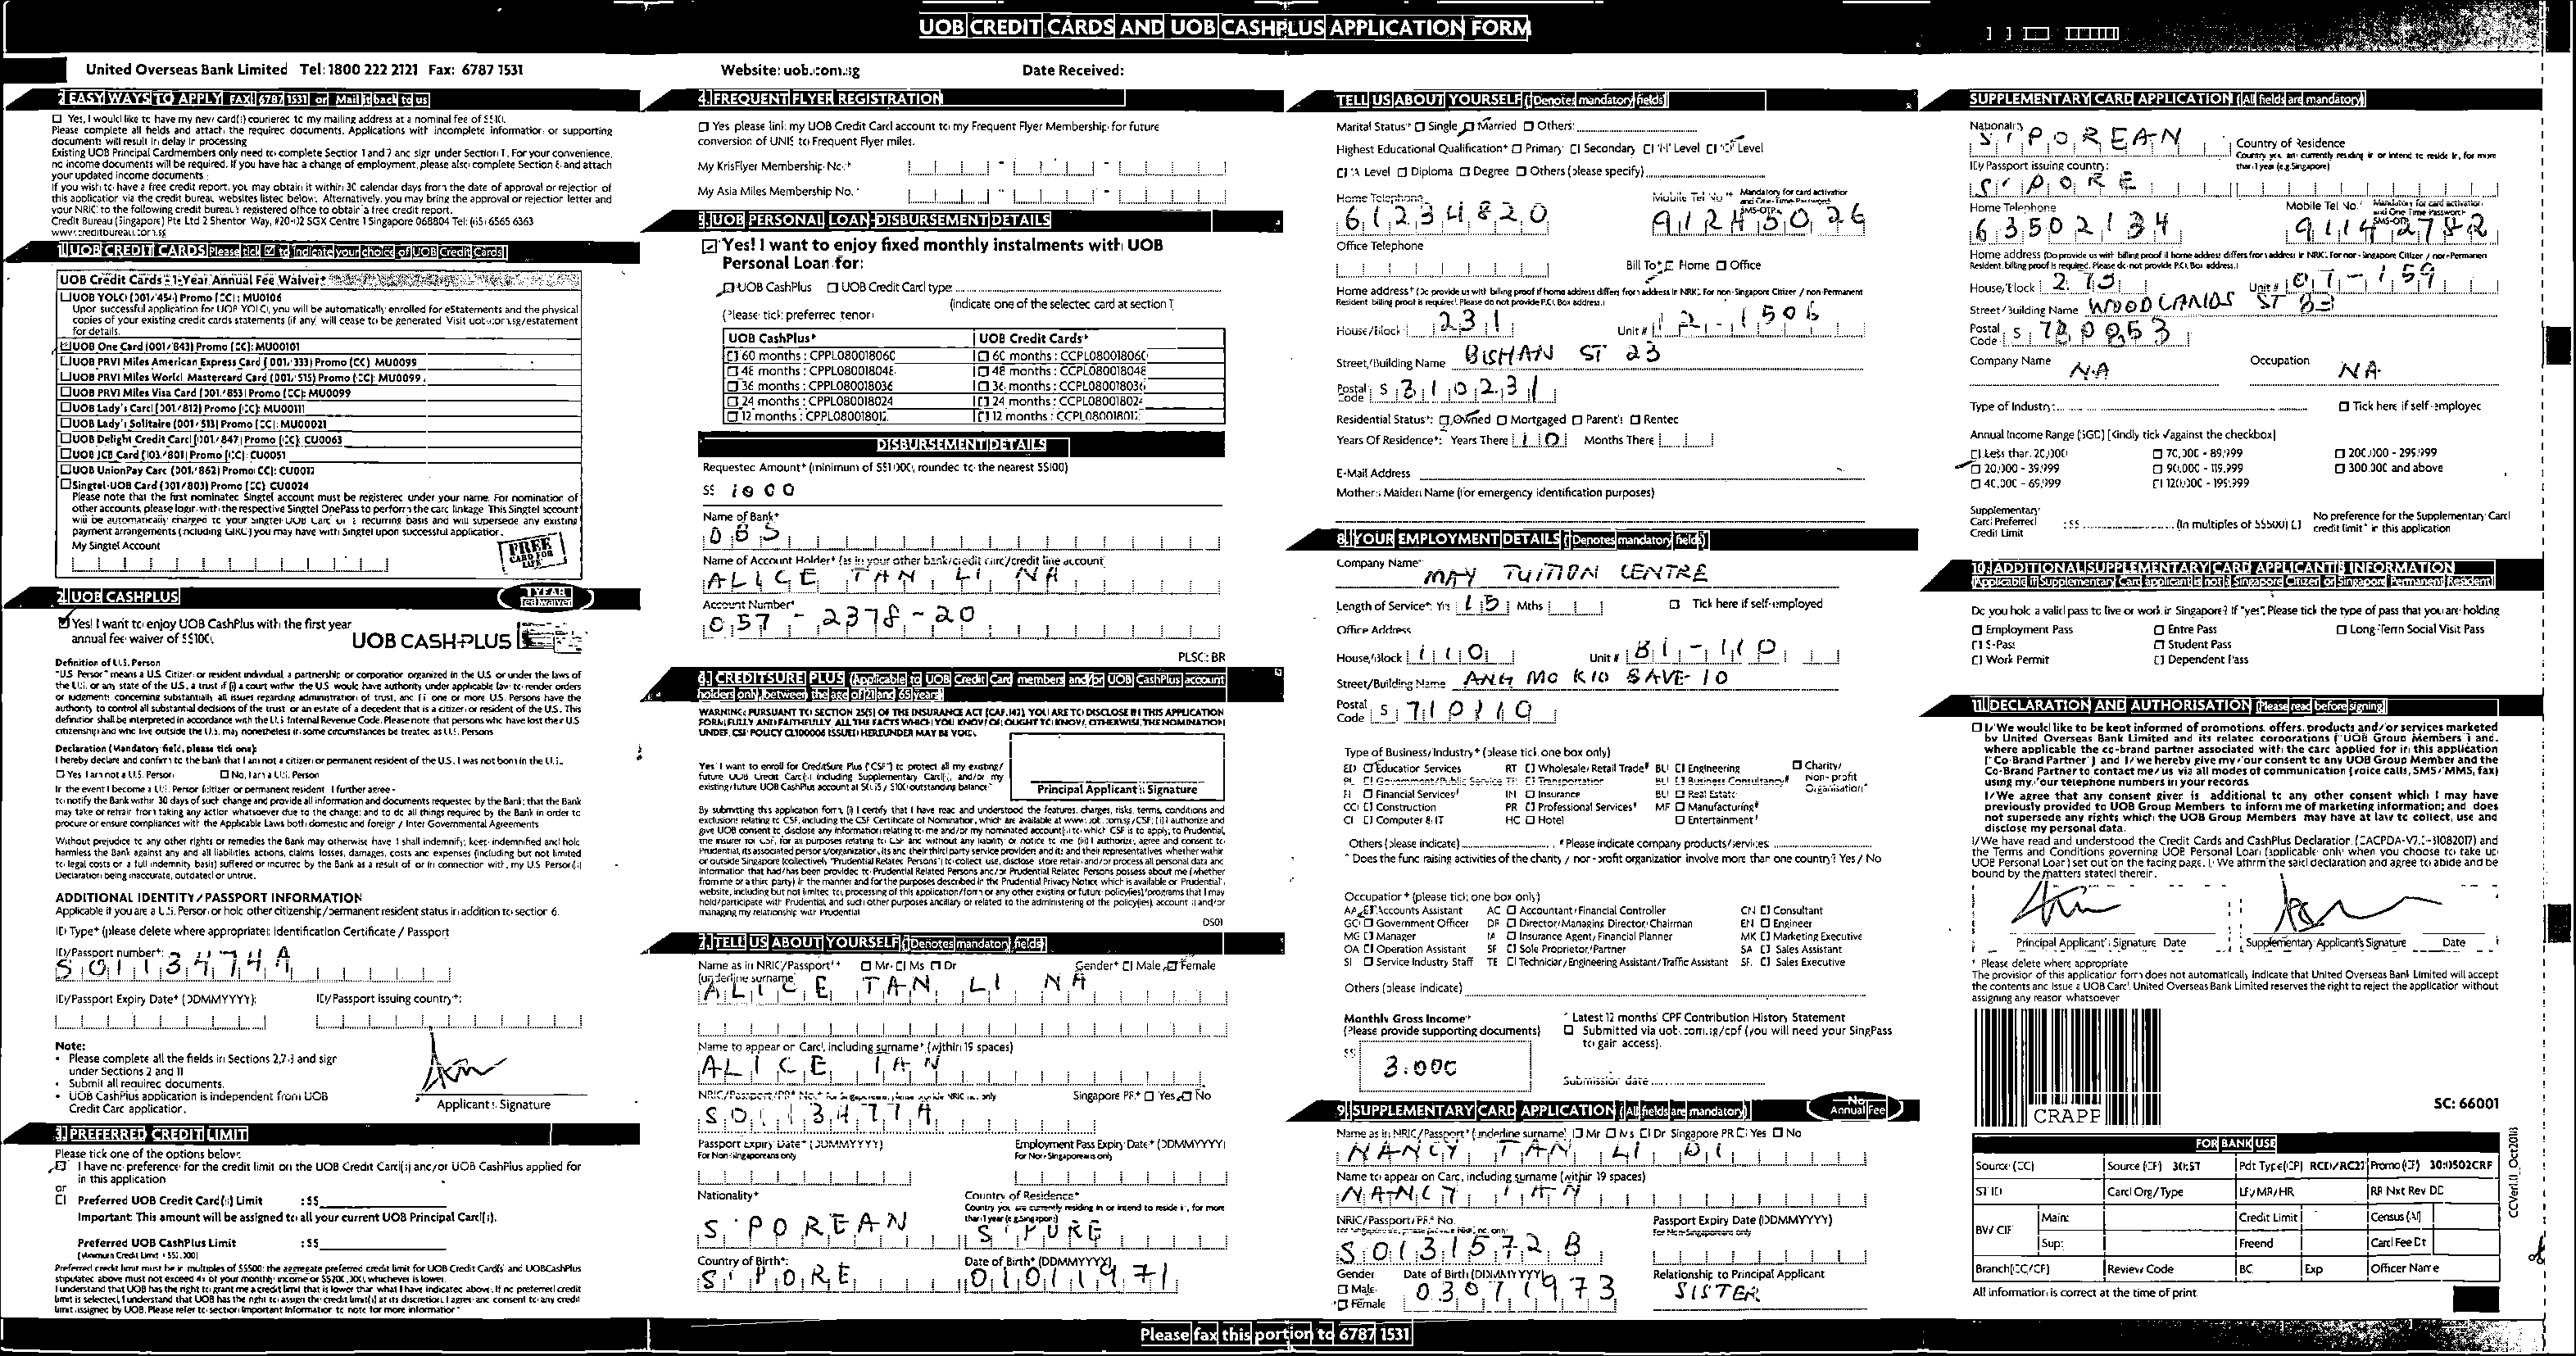

In [0]:
render_doc_text('ml-poc-213704-vcm/AliceTan.tif', 'gs://ml-poc-213704-vcm/upoad/output/')

>#### Full Credit Card Application for Phin Lee

Waiting for the operation to finish.
Output files:
upoad/output/output-1-to-1.json
Full text:
UOB CREDIT CARDS AND UOB CASHPLUS APPLICATION FORM
United Overseas Bank Limited Tel: 1800 222 2121 Fax: 6787 1531
*
*
-"-
-"--
-
--
SUPPLEMENTARY CARD APPLICATION (A fields are mandātory)
Nationality
Country of Residence
Country you are currently residing In or Intend to reside in for more
ID/Passport issuing country:
then l year leu. Singapore)
UUUUUUUUUUUUUUUUUUUU
Home Telephone
Mobile Tel No Mandatory for card activation
and One-Time Password
SMS-OTP
LILUUUUU
Home address (Do provide us with billing proof if home actress differs from address in NRIC For non-Singapore Citizen / non Permanent
Resident, billing proof is secured. Please do not provide PO Box address)
Unit # LLLLLLLL
Street/Building Name
Code" SUUULUU
Company Name
Occupation
-
--
PALLAAHUL
House/Block UUUU
2 EASY WAYS TO APPLY FAX: 6787 1531 or Mail it back to us'
Yes, I would like to have my new card(s) couriered to my mailing 

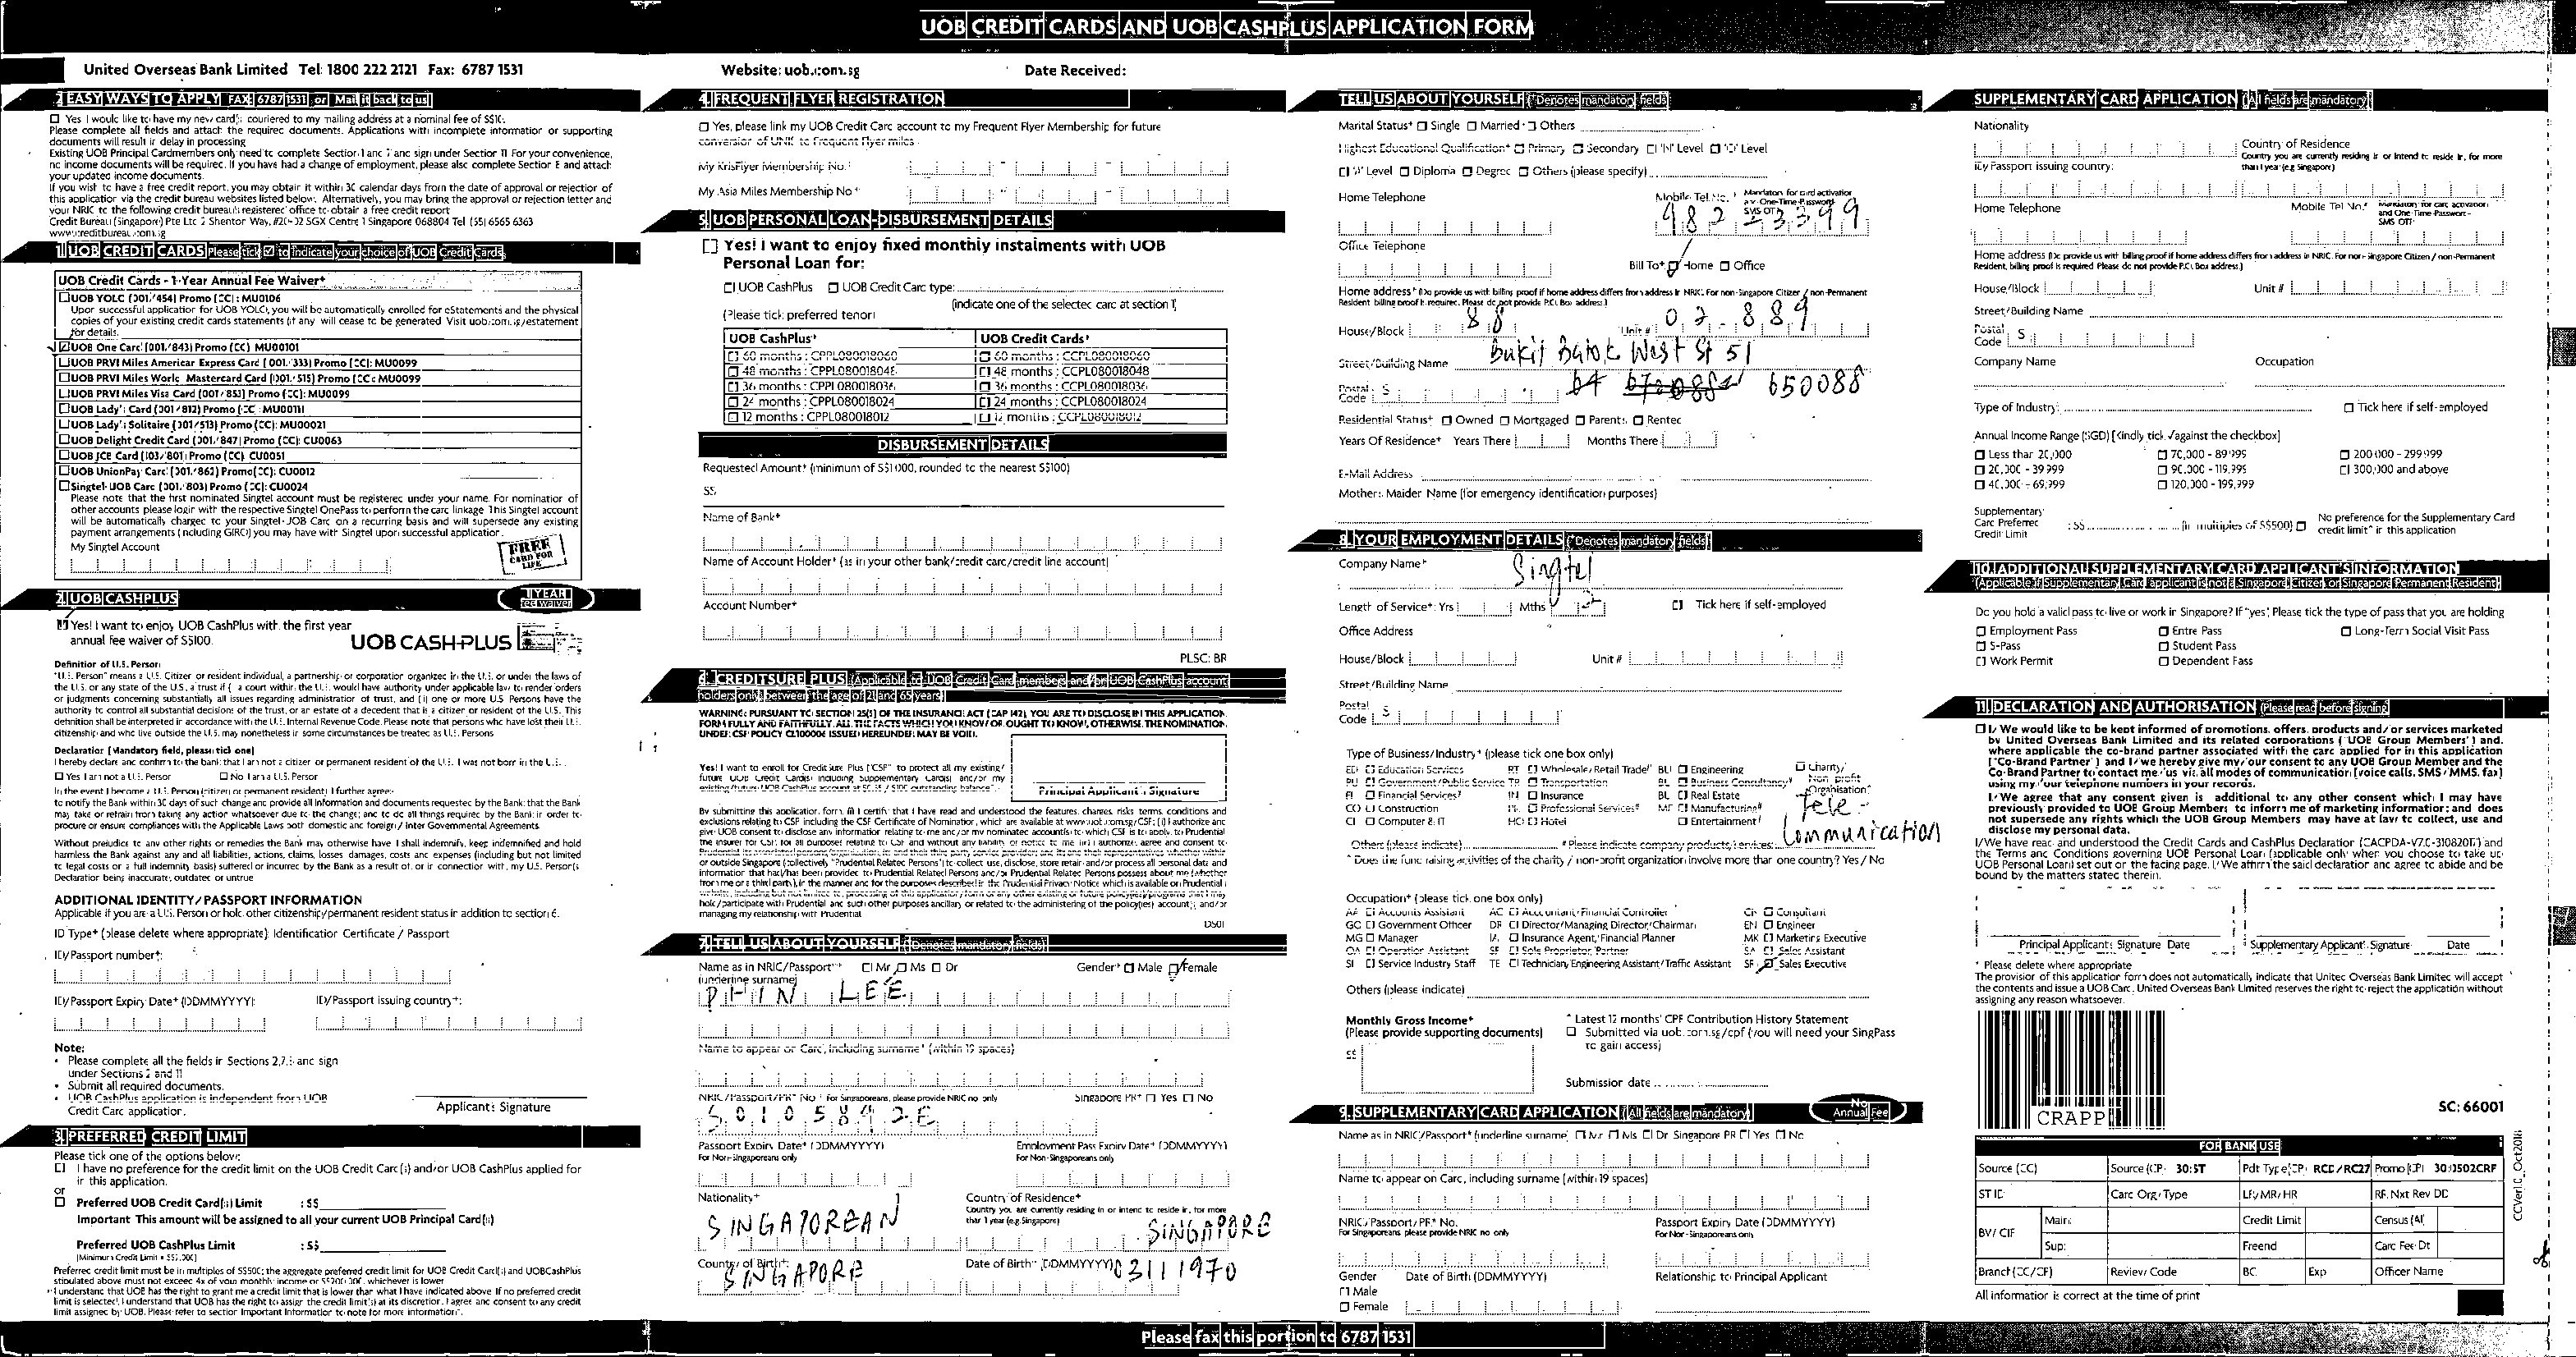

In [0]:
render_doc_text('ml-poc-213704-vcm/PhinLee.tif', 'gs://ml-poc-213704-vcm/upoad/output/')

> #### Full Credit Card Application for Pascal

Waiting for the operation to finish.
Output files:
upoad/output/output-1-to-1.json
Full text:
UOB CREDIT CARDS AND UOB CASHPLUS APPLICATION FORM
-
United Overseas Bank Limited Tel: 1800 222 2121 Fax: 6787 1531
-
-
TELL US ABOUT YOURSELF (Denotes mandatory fiela
Marital Statust a single a Married Others..........
Highest Educational Qualification Primary Secondary O'N' Level O 'O'Level
D'A' level Diploma Degree Others (please specify)..
Home Telephone
Mobile Tel. No *+ Mandatory for card activation
and One-Time-Password
MY I LLUI.
- -
SUPPLEMENTARY CARD APPLICATION (Allfields åre mandatory)
Nationality
UMMYLI UI . 1 Country of Residence
Country you are currently reshing in or intend to reside in for more
ID/Passport issuing country:
than lytur leg Singapore)
LLLLLLLLLLLLUMINIO
Home Telephone
Mobile Tel. No.' Mandatory for card activation
and One Time sex
- -
"
.
........
.
- - -
173,44,49.520
LINDONESIA
678.9.14.5.4 677198841
..0,6 0,3
- -,-
Website: uob.com.sg
Date Received:
4. FREQUEN

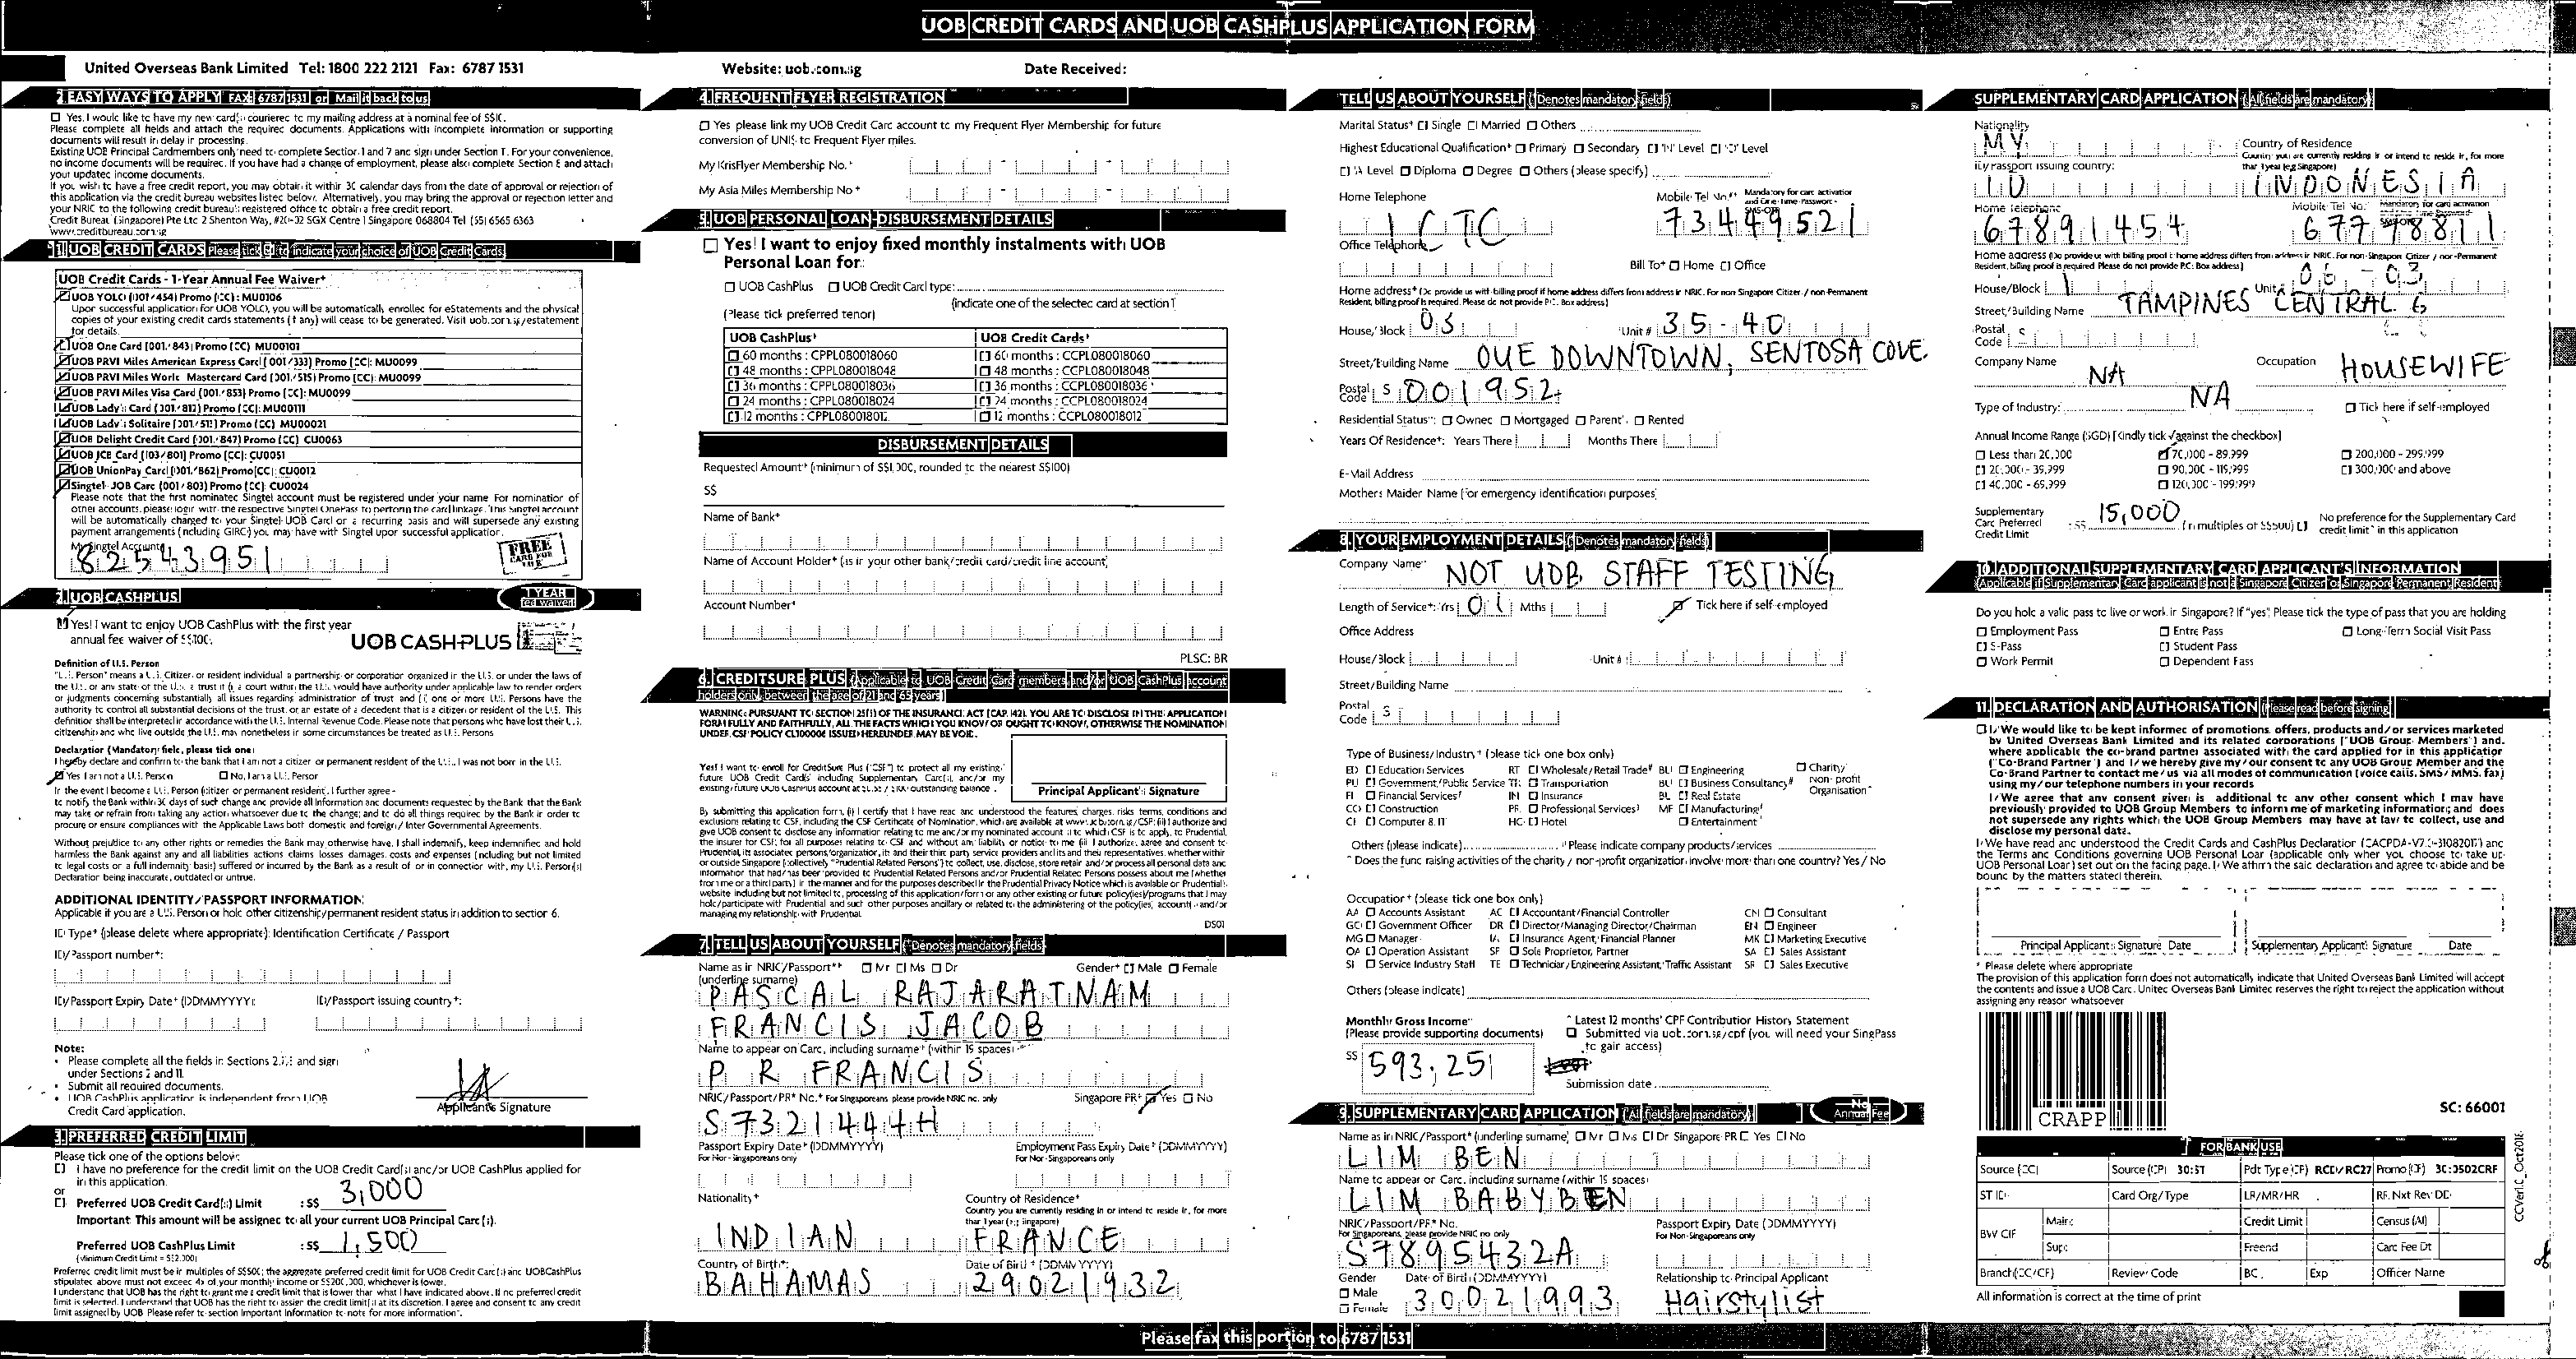

In [0]:
render_doc_text('ml-poc-213704-vcm/PascalRajaratnam.tif', 'gs://ml-poc-213704-vcm/upoad/output/')

#### Alice Tan "Tell Us About Yourself"

Waiting for the operation to finish.
Output files:
upoad/output/output-1-to-1.json
Full text:
DSOI
7. TELL US ABOUT YOURSELF (Denotes mandatory fields)
Name as in NRIC/Passport*+ O Mr. Ms Dr
Gender
Male
Female
ALE TAN LLENA
LLLLLLLLLLLLLLLULO
Name to appear on Card, including surname*.(within 19 spaces)
ALC,E, TANDUO
SO1:1,3,4,7,7,A.
NRIC/Passport/PR* No. for Singaporeons, please pravice NRIC no. only
Singapore PR* Yes No
UUU
Passport Expiry Date* (DDMMYYYY)
Employment Pass Expiry Date (DDMMYYYY)
For Non Singaporera only
for Norr-Singaporeanis only
LLLLLLL
UUUUUUUU
Nationality
Country of Residence
Country you are currently reside horintend to reside in for more
then your le Singapore
S'PO REAN
MUISTORUULU
Soy POR ELLO Toponimy: 77



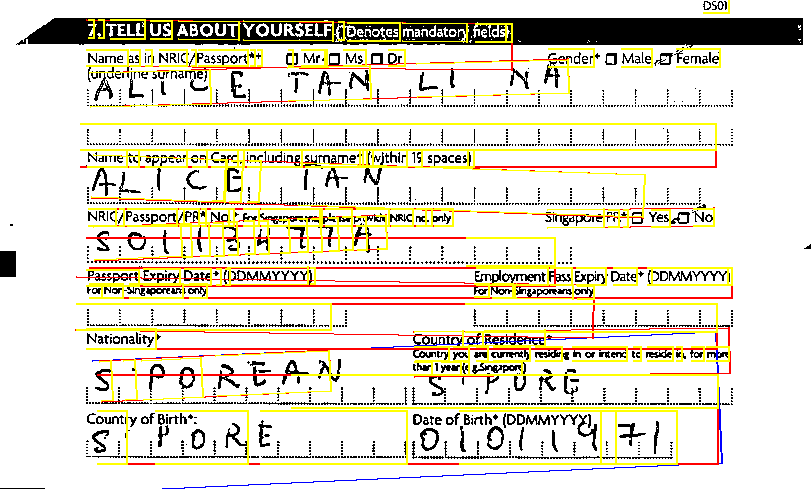

In [0]:
render_doc_text('ml-poc-213704-vcm/AliceTan-7A.tif', 'gs://ml-poc-213704-vcm/upoad/output/')

Waiting for the operation to finish.
Output files:
upoad/output/output-1-to-1.json
Full text:
TELL US ABOUT YOURSELF (Denotes mandatory fields)
Marital Status* Single A Married others. ...
Highest Educational Qualification Primary a Secondary O'N' Level O 'O' Level
O'A Level Diploma Degree Others (please specify)...
Home Telephone
Mobile Tel. No. + Mandatory for card activation
Indone-time Password-
:6(2,3,482.0.
AIRMADO JE
Office Telephone
LLLLLLLL
Bill To* Home
Office
Home address (Do provide us with billing proof of homa wodress differs from across In NRK. For non-Singapore Citizen / non Permanent
Resident, billing proof is required. Please do not provide P.O. Box address.)
po
Unit al Ri
ST 23
House/Block 1231
Street/Building Name BiSH AN
in s 311,0,2,3 |
Residential Status: q.owned Mortgaged
Years Of Residencet: Years There LLIO
Parent's Rented
Months There
L L
E-Mail Address
Mother's Maiden Name (for emergency identification purposes)
--..
..
.
..
..
.
..
.................
.....
.

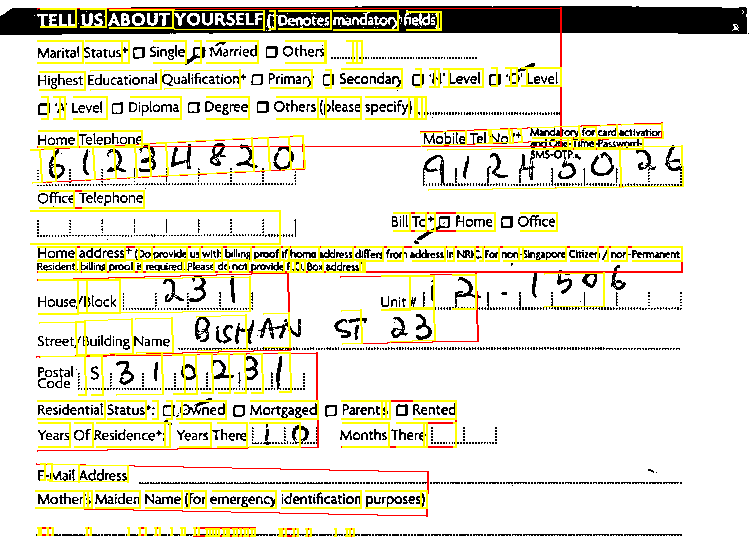

In [0]:
render_doc_text('ml-poc-213704-vcm/AliceTan-7B.tif', 'gs://ml-poc-213704-vcm/upoad/output/')

#### Phin Lee "Tell Us About Yourself"

Waiting for the operation to finish.
Output files:
upoad/output/output-1-to-1.json
Full text:
0501
ZA TELL US ABOUT YOURSELF (*Denotes mandatory fields
Name as in NRIC/Passport*+ Mr Ms Dr
Gender* () Male Female
(underline surnarne)
PAINULEEUUUUUUUUUUUU
ULLLLLLLLLLLLLLLLL
Name to appear on Card, including surname+ (within 19 spaces)
LLLLLLLLLLULLLLLLLL
NRIC/Passport/PR* No.- for Singaporeans, please provide NRIC no. only
Singapore PR+ Yes No
SO10 58.9.2E
Passport Expiry Date (DDMMYYYY)
Employment Pass Expiry Date+ (DDMMYYYY
for Non-Singaporeans only
For Non Singaporeans only
LLLLLLLL
Nationality
Country of Residence+
Country you are currently residing in or intend to reside in for more
SINGAPOREAN
than 1 year leg. Singapore
Sina
UUUUUUUUULIININ
course A POR
Date of Birth (DDMMYYYY0 31 1 1970
> IN 7
MILLILLLLOOOO
Please fax this portion



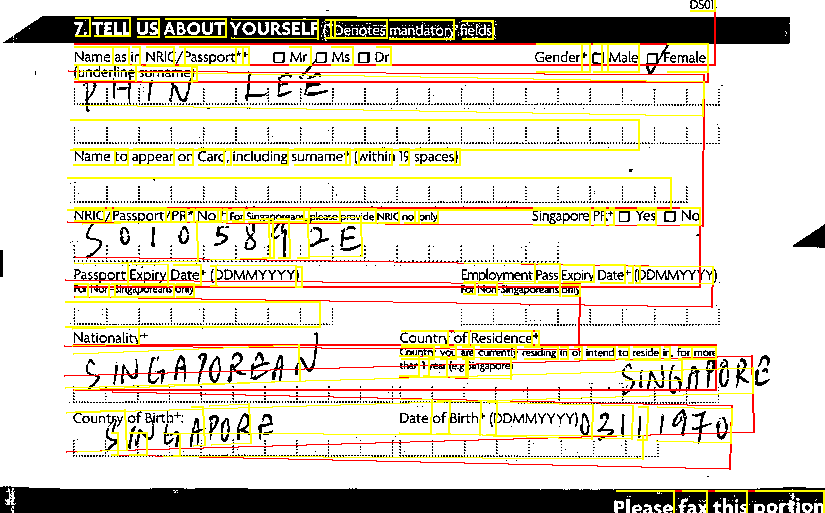

In [0]:
render_doc_text('ml-poc-213704-vcm/PhinLee-7A.tif', 'gs://ml-poc-213704-vcm/upoad/output/')

Waiting for the operation to finish.
Output files:
upoad/output/output-1-to-1.json
Full text:
TELL US ABOUT YOURSELF! Denotes mandatory fields
Marital Statust Single Married · Others:
...-... -----........ .
Highest Educational Qualification Primary Secondary O'N' Level O'OʻLevel
A Level Diploma Degree Others (please specify).
Home Telephone
Mobile Tel. No. Mandatory for card activation
and One Time Passwort!
LLLLLLLL
Office Telephone
UUUUUUU
Bill To* W Home Office
Home address (Do provide us with billing proof if home address differs from address in NRIC for non-Singapore Citizen / non Permanent
Resident, billing proof is required. Moyse do, pot provide P.O.Box address)
4,8.25903,3991
House/Block 1 1 88.
United 0,1,.,8,8.9
.
"Unit # L.............
Fun! Da
!
1
Street/Building Name
Postal S
A
fa 650085"
Code
Residential Status: Owned Mortgaged
Years Of Residencet: Years There L e
Parent's Rented
Months There-
L L
E-Mail Address ............... .. ..
..
Mother's Maiden Name (for emergenc

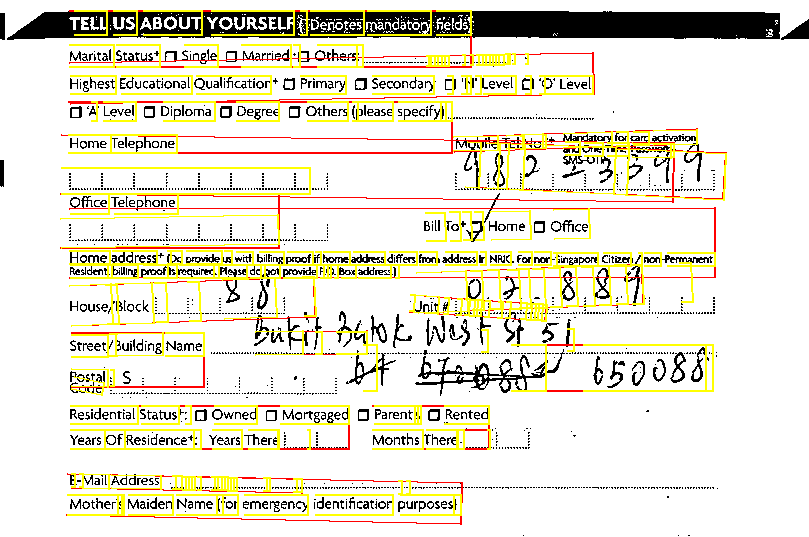

In [0]:
render_doc_text('ml-poc-213704-vcm/PhinLee-7B.tif', 'gs://ml-poc-213704-vcm/upoad/output/')

#### Pasacal "Tell Us About Yourself"

Waiting for the operation to finish.
Output files:
upoad/output/output-1-to-1.json
Full text:
пищу и притоа
DSOI
7. TELL US ABOUT YOURSELF denotes mandatory fields
Name as in NRIC/Passport*+ OM O Ms Dr
Gender Male Female
uteng STC AL RAJ ARALNAMID
FRANCISL JA CO.BIOLO
Name to appear on Card, including surname+ (within 19 spaces)
PR FRANCISUJIULIU
NRIC/Passport/PR* No.* For Singapore am please provide eRaC no. eonty Singapore PR* Yes No
9.73.21:44:4HULUU
ILU
Passport Expiry Date+ (DDMMYYYY)
Employment Pass Expiry Date+ (ODMMYYYY)
For Non-Singaporeans only
For Non-Singaporeans only
Nationality
Country of Residence+
Country you are currently residing in or intend to reside in for more
than 1 year leg.Singapore)
IND LAND FRANCE
BAHAMAS 12902 19:32
Please fax this portio



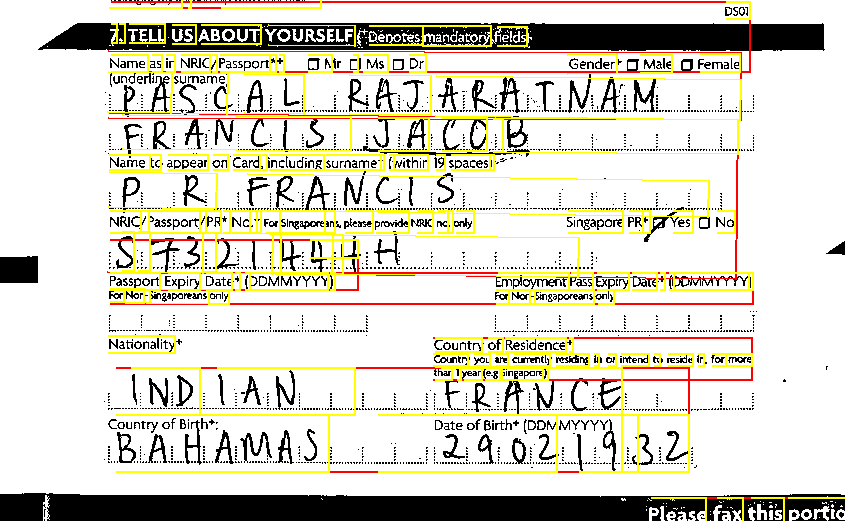

In [0]:
render_doc_text('ml-poc-213704-vcm/PascalRajaratnam-7A.tif', 'gs://ml-poc-213704-vcm/upoad/output/')

Waiting for the operation to finish.
Output files:
upoad/output/output-1-to-1.json
Full text:
...
'TELL US ABOUT YOURSELF ( Denotes mandatory fields),
Marital Status Single Married Others..............................
Highest Educational Qualification Primary Secondary O'N' Level O 'O' Level
D'A' level Diploma Degree Others (please specify)............
Home Telephone
Mobile Tel No.1 and One Time Password-
Mobile Talmat Mandatory for card activation
SM5-OH
17.3.449.5210
Office Telephone
LLLLLLL
Bill To+ oHome Office
Home address (Do provide us with billing proof if home attress differs from address in NRIC for norr Singapore Citizen / non Permanent
Resident, biting proof is required. Please do not provide PO, Box address)
House/block: 03L1 Unie 35-40LI
Street/Building Nome OVE DOWNTOWN, SENTOSA COVE
Postal 50019512
Street/Building Name
Residential Status: Owned Mortgaged
Years Of Residencet: Years There L O
Parent's Rented
Months There L L
E-Mail Address
Mother's Maiden Name (for emerge

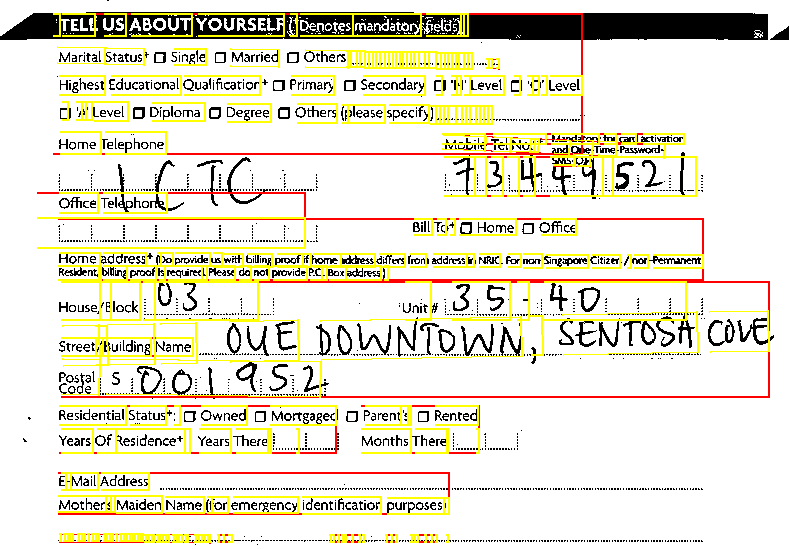

In [0]:
render_doc_text('ml-poc-213704-vcm/PascalRajaratnam-7B.tif', 'gs://ml-poc-213704-vcm/upoad/output/')

#### Alice Tan 7A - PNG


Block confidence: 0.80

Paragraph confidence: 0.80
Word text: DSOI (0.8)

Block confidence: 0.86

Paragraph confidence: 0.86
Word text: 7 (1.0)
Word text: . (1.0)
Word text: TELL (1.0)
Word text: US (0.9)
Word text: ABOUT (0.9)
Word text: YOURSELF (1.0)
Word text: ( (0.4)
Word text: Denotes (0.8)
Word text: mandatory (0.9)
Word text: fields (1.0)
Word text: ) (0.7)
Word text: Name (0.9)
Word text: as (0.9)
Word text: in (1.0)
Word text: NRIC (1.0)
Word text: / (1.0)
Word text: Passport (0.9)
Word text: * (1.0)
Word text: * (0.9)
Word text: Mr (0.7)
Word text: . (0.5)
Word text: OMS (0.1)
Word text: ODO (0.2)
Word text: ( (1.0)
Word text: underline (0.8)
Word text: surname (1.0)

Block confidence: 0.81

Paragraph confidence: 0.81
Word text: Gender (1.0)
Word text: * (0.1)
Word text: O (0.1)
Word text: Male (0.9)

Block confidence: 0.94

Paragraph confidence: 0.94
Word text: Female (0.9)

Block confidence: 0.50

Paragraph confidence: 0.50
Word text: 112 (0.5)
Word text: , (0.9)
Word tex

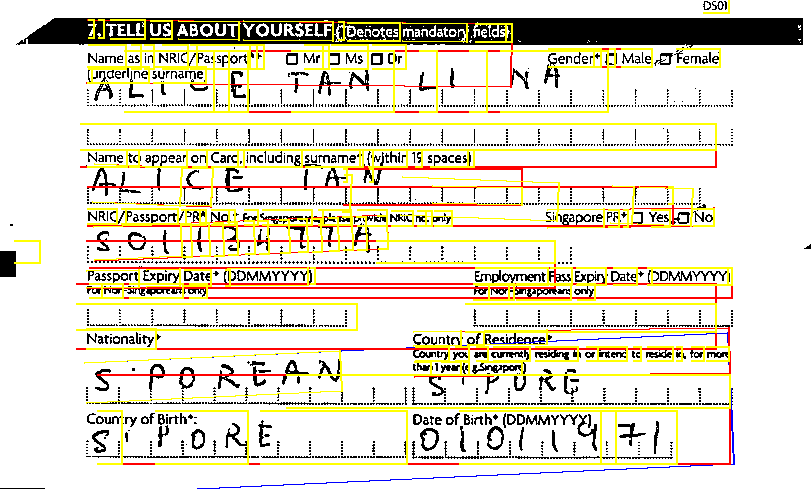

In [28]:
render_doc_text('ml-poc-213704-vcm/AliceTan-7A.png', 0)


Block confidence: 0.96

Paragraph confidence: 0.96
Word text: Date (1.0)
Word text: of (1.0)
Word text: Birth (1.0)
Word text: ( (0.9)
Word text: DDMMYYYY (0.9)
Word text: ) (0.9)

Block confidence: 0.33

Paragraph confidence: 0.33
Word text: o (0.4)
Word text: long (0.3)
Word text: , (0.2)
Word text: 71 (0.4)
Full text:
Date of Birth (DDMMYYYY)
o long, 71



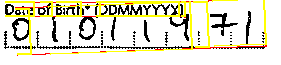

In [29]:
render_doc_text('ml-poc-213704-vcm/AliceTan-DOB.png', 0)


Block confidence: 0.94

Paragraph confidence: 0.94
Word text: Name (1.0)
Word text: to (1.0)
Word text: appear (1.0)
Word text: on (1.0)
Word text: Card (1.0)
Word text: , (1.0)
Word text: including (1.0)
Word text: surname (1.0)
Word text: * (0.9)
Word text: ( (0.7)
Word text: within (0.7)
Word text: 19 (0.9)
Word text: spaces (1.0)
Word text: ) (1.0)

Block confidence: 0.35

Paragraph confidence: 0.35
Word text: ALICEAVAL (0.3)
Full text:
Name to appear on Card, including surname*(within 19 spaces)
ALICEAVAL



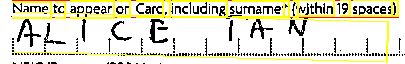

In [30]:
render_doc_text('ml-poc-213704-vcm/AliceTan-Name.png', 0)


Block confidence: 0.78

Paragraph confidence: 0.78
Word text: NRIC (1.0)
Word text: / (1.0)
Word text: Passport (1.0)
Word text: / (1.0)
Word text: PR (1.0)
Word text: * (1.0)
Word text: Not (0.8)
Word text: For (0.9)
Word text: Singapore (0.8)
Word text: , (0.8)
Word text: please (0.6)
Word text: populace (0.4)

Block confidence: 0.78

Paragraph confidence: 0.78
Word text: 3 (0.6)
Word text: , (0.7)
Word text: 0 (0.9)
Word text: , (0.4)
Word text: 1 (0.9)
Word text: , (0.8)
Word text: 1 (0.9)
Word text: , (0.9)
Word text: 3 (0.8)
Word text: , (0.7)
Word text: 4 (0.9)
Word text: , (1.0)
Word text: 7 (1.0)
Word text: , (0.9)
Word text: 4 (0.6)
Full text:
NRIC/Passport/PR* Not For Singapore, please populace
3,0,1,1,3,4,7,4



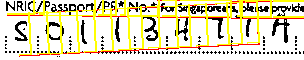

In [31]:
render_doc_text('ml-poc-213704-vcm/AliceTan-NRIC.png', 0)




#### PascalRajaratnam-7A - *PNG*





Block confidence: 0.88

Paragraph confidence: 0.88
Word text: Date (1.0)
Word text: of (1.0)
Word text: Birth (1.0)
Word text: + (0.4)
Word text: ( (0.9)
Word text: DOMMYYYY (0.9)
Word text: ) (0.4)
Word text: , (0.5)

Block confidence: 0.77

Paragraph confidence: 0.77
Word text: 29 (0.9)
Word text: : (0.4)
Word text: 02 (1.0)
Word text: 19 (0.5)
Word text: : (0.5)
Word text: 32 (1.0)
Full text:
Date of Birth+ (DOMMYYYY),
29:02 19:32



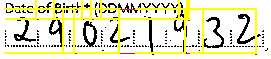

In [32]:
render_doc_text('ml-poc-213704-vcm/PascalRajaratnam-DOB.png', 0)


Block confidence: 0.97

Paragraph confidence: 0.97
Word text: Name (1.0)
Word text: to (0.9)
Word text: appear (1.0)
Word text: on (1.0)
Word text: Card (1.0)
Word text: , (1.0)
Word text: including (1.0)
Word text: surname (1.0)
Word text: + (0.9)
Word text: ( (0.9)
Word text: within (0.9)
Word text: 19 (0.9)
Word text: spaces (1.0)
Word text: ) (1.0)

Block confidence: 0.76

Paragraph confidence: 0.76
Word text: IP (0.6)
Word text: IR (0.5)
Word text: FRANCIS (0.9)
Full text:
Name to appear on Card, including surname+ (within 19 spaces)
IP IR FRANCIS



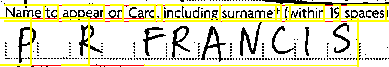

In [33]:
render_doc_text('ml-poc-213704-vcm/PascalRajaratnam-Name.png', 0)


Block confidence: 0.80

Paragraph confidence: 0.80
Word text: NRIC (1.0)
Word text: / (0.9)
Word text: Passport (1.0)
Word text: / (1.0)
Word text: PR (1.0)
Word text: * (0.4)
Word text: Not (0.5)
Word text: For (0.8)
Word text: Singaporeans (0.7)
Word text: , (0.9)
Word text: please (0.7)
Word text: provide (0.9)
Word text: NORAC (0.7)

Block confidence: 0.57

Paragraph confidence: 0.57
Word text: 5 (0.7)
Word text: . (0.8)
Word text: 73 (0.9)
Word text: . (0.3)
Word text: 214 (0.4)
Word text: . (0.1)
Word text: 4 (0.8)
Word text: . (0.4)
Word text: 4 (0.8)
Word text: . (0.3)
Word text: 4 (0.8)
Word text: . (0.8)
Word text: 4 (0.1)
Full text:
NRIC/Passport/PR* Not For Singaporeans, please provide NORAC
5.73.214.4.4.4.4



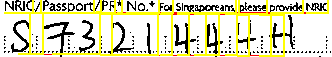

In [34]:
render_doc_text('ml-poc-213704-vcm/PascalRajaratnam-NRIC.png', 0)